In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
model_folder = '/content/drive/MyDrive/GM Project/VQGAN Project/model'
helper_methods_folder = '/content/drive/MyDrive/GM Project/VQGAN Project/utils'

sys.path.append(os.path.abspath(model_folder))
sys.path.append(os.path.abspath(helper_methods_folder))

Importing the required libraries

In [3]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils as vutils
from transformer import VQGANTransformer
from utils import load_data, plot_images

In [4]:
import warnings
warnings. filterwarnings("ignore")

In [5]:
def configure_optimizers():
    decay, no_decay = set(), set()
    whitelist_weight_modules = (nn.Linear, )
    blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

    for mn, m in model.transformer.named_modules():
        for pn, p in m.named_parameters():
            fpn = f"{mn}.{pn}" if mn else pn

            if pn.endswith("bias"):
                no_decay.add(fpn)

            elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                decay.add(fpn)

            elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                no_decay.add(fpn)

    no_decay.add("pos_emb")

    param_dict = {pn: p for pn, p in model.transformer.named_parameters()}

    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.01},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]

    optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06, betas=(0.5, 0.95))
    return optimizer

In [6]:
model = VQGANTransformer().to(device="cuda")
optim = configure_optimizers()

100%|██████████| 982/982 [34:15<00:00,  2.09s/it, Transformer_Loss=2.73]


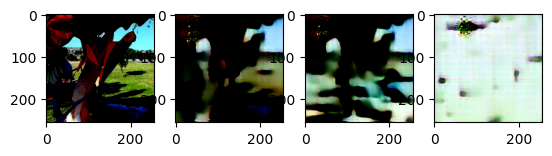

100%|██████████| 982/982 [30:22<00:00,  1.86s/it, Transformer_Loss=2.63]


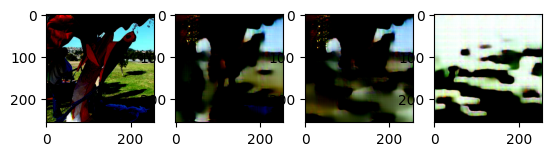

100%|██████████| 982/982 [30:25<00:00,  1.86s/it, Transformer_Loss=2.6]


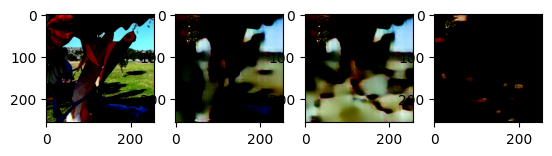

100%|██████████| 982/982 [30:22<00:00,  1.86s/it, Transformer_Loss=2.6]


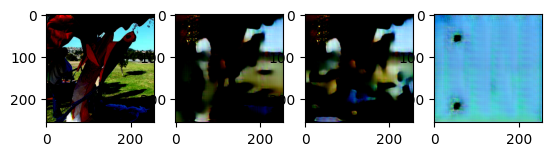

100%|██████████| 982/982 [30:27<00:00,  1.86s/it, Transformer_Loss=2.59]


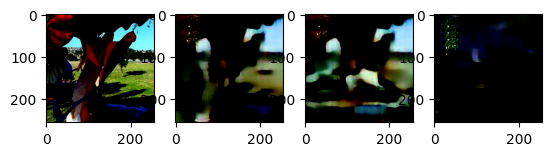

100%|██████████| 982/982 [30:32<00:00,  1.87s/it, Transformer_Loss=2.58]


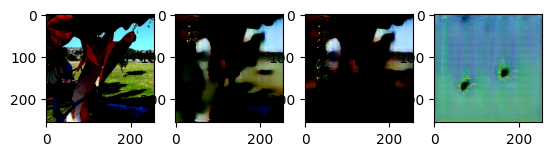

100%|██████████| 982/982 [30:31<00:00,  1.86s/it, Transformer_Loss=2.58]


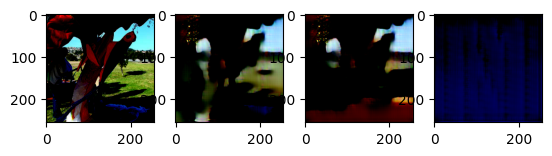

100%|██████████| 982/982 [30:36<00:00,  1.87s/it, Transformer_Loss=2.59]


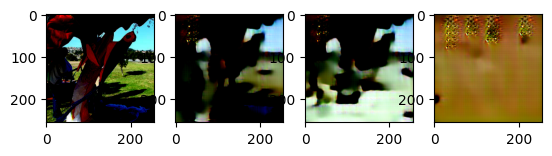

 92%|█████████▏| 904/982 [28:07<02:24,  1.86s/it, Transformer_Loss=2.48]

In [ ]:
train_dataset = load_data(dataset_path="/content/drive/MyDrive/GM Project/coco2017")
for epoch in range(20):
    with tqdm(range(len(train_dataset))) as pbar:
        for i, imgs in zip(pbar, train_dataset):
            optim.zero_grad()
            imgs = imgs.to(device="cuda")
            logits, targets = model(imgs)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
            loss.backward()
            optim.step()
            pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
            pbar.update(0)
    log, sampled_imgs = model.log_images(imgs[7][None])
    vutils.save_image(sampled_imgs, os.path.join("/content/drive/MyDrive/GM Project/transformer_results/", f"transformer_{epoch}.jpg"), nrow=4)
    plot_images(log)
    torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/GM Project/transformer_checkpoints/", f"transformer_{epoch}.pt"))